## LDA 3

# Fitting an LDA to our corpus

We plan to perform topic modeling using *Latent Dirichlet Allocation* (abbreviated as LDA). An LDA is a *generative model* that learns a group of categories (or *topics*) for words that occur together in a corpus of documents. For a technical presentation of LDAs, see [Appendix A](404).

Let's start loading up our corpus:

In [2]:
import json
import re
import os
import sys 

# Jupyter Notebooks are not good at handling relative imports.
# Best solution (not great practice) is to add the project's path
# to the module loading paths of sys.

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.loaders import loadCorpusList, saveCorpus

corpusPath = '../data/clean_json'

corpusList = loadCorpusList(corpusPath)
corpusList = [a for a in corpusList if a.lang == "es"]

In [3]:
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation

from wordcloud import WordCloud

## Creating the term-document matrix

LDAs accept as input a bag-of-words representation of each document. In this representation, we build a matrix in which each column represents a word (lemmatized and in lowercase in our analysis), and each row is a document. Thus, if the matrix is called $X$, the entry $X_{ij}$ is given by how many times word $j$ appears in document $i$.

Thankfully, there is a simple way of constructing the term-document matrix using auxiliary tools from `scikit-learn`.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
documents = [a.bagOfWords for a in corpusList]

In [6]:
vec = CountVectorizer(min_df=10)
X = vec.fit_transform(documents)

## Counting most frequent words

Now, `X` contains the term-document matrix. We can re-check what the most frequent words by adding over all columns.

In [7]:
from operator import itemgetter

In [8]:
counts = {
    word: count for word, count in zip(vec.get_feature_names(), X.sum(axis=0).tolist()[0])
}
sorted_counts = list(counts.items())
sorted_counts.sort(key=itemgetter(1), reverse=True)

for i, wordcount in enumerate(sorted_counts[:10]):
    print(f"{i+1}, {wordcount}")

1, ('ser', 12803)
2, ('formar', 5931)
3, ('bien', 5433)
4, ('mundo', 5186)
5, ('político', 4857)
6, ('filosofía', 4736)
7, ('modo', 4654)
8, ('vida', 3963)
9, ('moral', 3904)
10, ('ideo', 3900)


TODO: `idea` is being transformed to `ideo`.

And, using this dictionary, we can create a simple wordcloud:

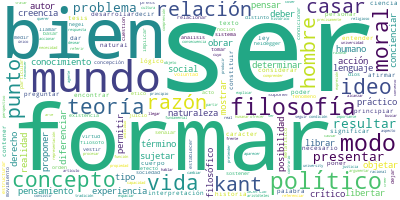

In [9]:
wordcount = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue').generate_from_frequencies(counts)
wordcount.to_image()

### Storing the term-document matrix in a csv

We can use `pandas` to easily store the term-document matrix:

In [10]:
df = pd.DataFrame(X.todense(), columns=vec.get_feature_names())

In [11]:
df

,aa,ab,abajar,abandonar,abandonarse,abar,abarcador,abarcar,aber,abiertamente,...,órgano,últimamente,únicamente,único,útil,über,überhaupt,žižek,καὶ,τὸ
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,3,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,3,1,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,1,...,0,0,1,3,4,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
551,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
with open("../data/tdm.csv", "w") as fp:
    fp.write(df.to_csv(index=False))

## Fitting an LDA

In [13]:
n_topics = 50 # k in our notation.

LDA = LatentDirichletAllocation(n_components=n_topics)
LDA.fit(X)

LatentDirichletAllocation(n_components=50)

In [14]:
n_top_words=10
for topic_idx, topic in enumerate(LDA.components_):
    message = "Topic #%d: " % topic_idx
    message += " ".join([df.columns[i]
                         for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic #0: filosofía experiencia hermenéutico lenguaje concepto imagen comprensión filosófico interpretación significar
Topic #1: social ser desarrollar personar perspectivo sistema sujetar procesar humanar concepto
Topic #2: hombre posibilidad angustiar ser kierkegaard concepto espíritu arendt promesa frente
Topic #3: acción agente accionar librar libertar ser prejuicio alternativo posibilidad actuar
Topic #4: teoría ser argumentación autor lógico científico formar problema ideo explicación
Topic #5: vattimo lenguaje místico palabra literario ser sartre comprensión hermenéutico metáfora
Topic #6: político religioso religión ético derecho social moral ser público habermas
Topic #7: kant derecho ser moral ley político naturaleza libertar razón hombre
Topic #8: sócrates macintyre diálogo tradición voluntariamente capacidad conocimiento hombre involuntariamente bien
Topic #9: hegel lógico hegeliano ser filosofía pensar dialéctico concepto marx formar
Topic #10: em uma um não apel na discur

## Saving the LDA model using `joblib`

In [1]:
from joblib import dump

In [17]:
dump(LDA, "LDA_k_50.jl")

['LDA_k_50.jl']